# **Predict House Pricing**

## Objectives

*   Fit and evaluate a regression model to predict the house price in the area of Ames, Iowa.

## Inputs

* outputs/datasets/collection/house_prices_ames_iowa.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house price
* labels map
* Feature Importance Plot

## Credit
* Portions of this code come from the Churnometer worlthrough project from Code Institute course.

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir


'/workspace/housing-price-data-ml/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")


You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir


'/workspace/housing-price-data-ml'

# Load Data

Loading the data and dropping features not relevant for the model according with the House price study completed prior.
Check House_price_study.ipynb present in this same folder for further details.

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/house_prices_ames_iowa.csv")
      .drop(labels=[
            '2ndFlrSF',
            'BedroomAbvGr',
            'BsmtExposure',
            'BsmtFinSF1',
            'BsmtFinType1',
            'BsmtUnfSF',
            'EnclosedPorch',
            'GarageFinish',
            'LotArea',
            'LotFrontage',
            'MasVnrArea',
            'OpenPorchSF',
            'OverallCond',
            'WoodDeckSF'
            ], axis=1)
      )

print(df.shape)
df.head(3)


(1460, 10)


,1stFlrSF,GarageArea,GarageYrBlt,GrLivArea,KitchenQual,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,548,2003.0,1710,Gd,7,856,2003,2003,208500
1,1262,460,1976.0,1262,TA,6,1262,1976,1976,181500
2,920,608,2001.0,1786,Gd,7,920,2001,2002,223500


---

# Creating ML Pipeline

Section 2 content

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # DATA CLEANING:
        # Replaces missing data with mean value
        ("MeanMedianImputer", MeanMedianImputer(imputation_method='mean',
                                                variables=['GarageYrBlt'])),

        # CATEGORICAL AND NUMERICAL TRANSFORMATIONS:
        # Converting categorical values of this feature in numerical values
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),

        ("LogTransformer", vt.LogTransformer(
            variables=['1stFlrSF'])),

        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
            variables=['GarageArea', 'GrLivArea'])),

        ("PowerTransformer", vt.PowerTransformer(
            variables=['TotalBsmtSF'])),

        # Feature selection is not needed

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


The SmartCorrelatedSelection with Spearman method, threshold of 0.6 and selection method "variance" gave this as result has the best algorithm:<br>
4 AdaBoostRegressor with a mean score of **0.642344**

Omitting the SmartCorrelatedSelection the result was higher with:<br>
4 AdaBoostRegressor with a mean score of **0.736936**

This result and the fact that it did't impact the speed performance either, made me decide to omit the SmartCorrelatedSelection at the moment until further model performance evaluation.


### Custom class for Hyperparameter Optimisation

From Code Institute - Churnometer walkthrough project

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train and Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 9) (1168,) 
* Test set: (292, 9) (292,)


## Grid Search CV - Sklearn

Using default hyperparameters to find the most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Hyperparameter optimisation using the default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
4,AdaBoostRegressor,0.625137,0.736936,0.783624,0.057617
0,LinearRegression,0.670201,0.710866,0.753788,0.03183
5,GradientBoostingRegressor,0.559444,0.699791,0.79911,0.095936
2,RandomForestRegressor,0.630557,0.693641,0.755985,0.045419
6,XGBRegressor,0.637822,0.67607,0.711843,0.027401
3,ExtraTreesRegressor,0.606672,0.664954,0.734752,0.052973
1,DecisionTreeRegressor,0.471908,0.567901,0.667303,0.076121


### Search for the best hyperparameter configuration

In [11]:
models_search = {
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
}


params_search = {
    "AdaBoostRegressor": {
        'model__n_estimators': [1, 3000],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
3,AdaBoostRegressor,0.65197,0.737812,0.795472,0.05098,0.01,3000
1,AdaBoostRegressor,0.651224,0.73362,0.794296,0.054496,0.1,3000
5,AdaBoostRegressor,0.640372,0.728266,0.769731,0.047959,0.001,3000
0,AdaBoostRegressor,0.491622,0.648899,0.748382,0.084688,0.1,1
2,AdaBoostRegressor,0.491622,0.648899,0.748382,0.084688,0.01,1
4,AdaBoostRegressor,0.491622,0.648899,0.748382,0.084688,0.001,1


AdaBoostRegressor Documentation - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn-ensemble-adaboostregressor


Attempted to run different values as number of estimators according to the AdaBoostRegressor documentation and recorded that the best mean score of 0.737812 did non improve after increasing the n_estimators above 3000. Even bigger numbers (attempted with 1000000 as maximum) did not improve this score.

Finding the best model

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'AdaBoostRegressor'

Parameters for best model

In [15]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01, 'model__n_estimators': 3000}

Define the best regressor, based on search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('MeanMedianImputer',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['GarageYrBlt'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('LogTransformer', LogTransformer(variables=['1stFlrSF'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GarageArea', 'GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostRegressor(random_state=0))),
                ('model',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=3000,
                                   random_state=0))])

---

## Assess feature importance

* These are the 3 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'TotalBsmtSF']


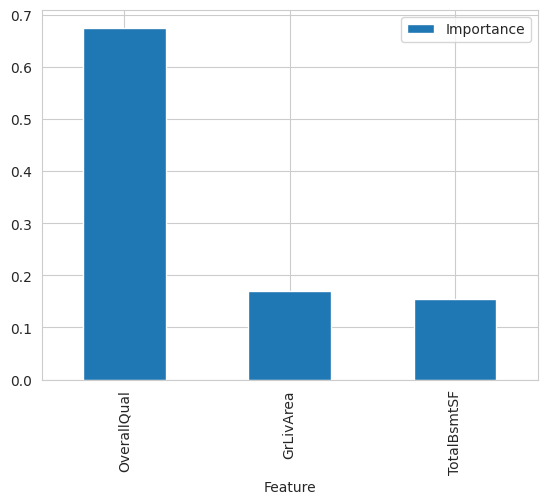

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# data cleaning and feature engineering steps that the pipeline has
data_cleaning_feat_eng_steps = 5
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.827
Mean Absolute Error: 25069.73
Mean Squared Error: 1067019852.953
Root Mean Squared Error: 32665.27


* Test Set
R2 Score: 0.813
Mean Absolute Error: 25099.809
Mean Squared Error: 1289982975.095
Root Mean Squared Error: 35916.333




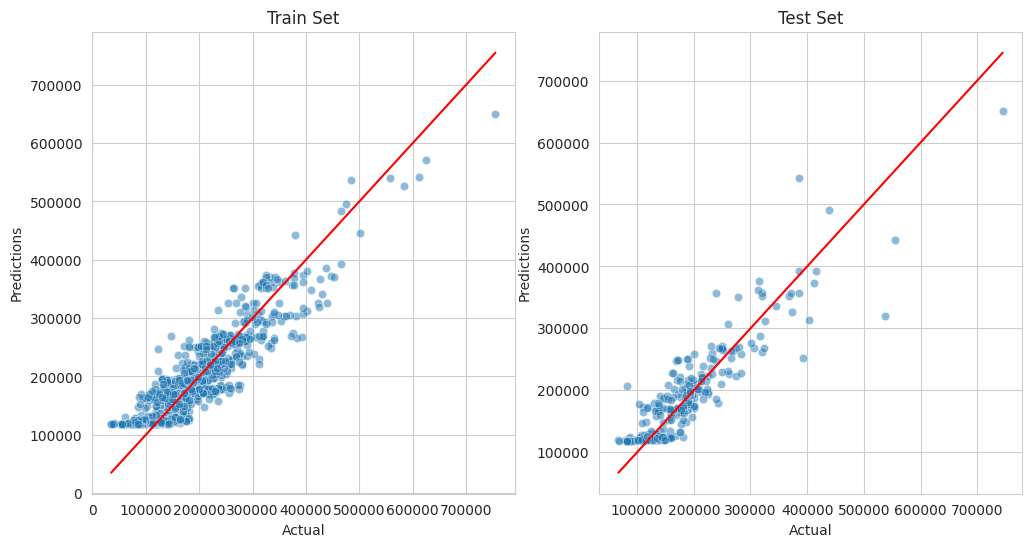

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

In our business case I agreed with the client an R2 score of at least 0.75 on the train set as well as on the test set whould have been a successful and satisfiyng result.

The R2 Score result is currently:<br>
Train Set: 0.827<br>
Test Set: 0.813<br>

This is above our expectations and it is an excellent result.

In [20]:
best_features

['GrLivArea', 'OverallQual', 'TotalBsmtSF']

---

## Refitting the pipeline with the Best Features

Since the number of features reported as most important are 3, I will attempt to refit the pipeline with only these features for efficiency and evauate how the performance of the model is affected by it.

In [21]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # CATEGORICAL AND NUMERICAL TRANSFORMATIONS:
        # Converting categorical values of this feature in numerical values
        ("YeoJohnsonTransformer", vt.YeoJohnsonTransformer(
            variables=['GrLivArea'])),

        ("PowerTransformer", vt.PowerTransformer(
            variables=['TotalBsmtSF'])),

        # Feature selection is not needed

        ("feat_scaling", StandardScaler()),

        ("model", model),

    ])

    return pipeline_base


Splitting Train and Test set with the best features

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 9) (1168,) 
* Test set: (292, 9) (292,)


In [23]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(5)

* Train set: (1168, 3) (1168,) 
* Test set: (292, 3) (292,)


,GrLivArea,OverallQual,TotalBsmtSF
618,1828,9,1822
870,894,5,894
92,964,5,876
817,1689,8,1568
302,1541,7,1541


Reviewing the best model and hyperparameters tested previously with the larger set of features

In [24]:
models_search

{'AdaBoostRegressor': AdaBoostRegressor(random_state=0)}

In [25]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01, 'model__n_estimators': 3000}

In [26]:
best_hyperparameters = {
    "AdaBoostRegressor": {
        'model__n_estimators': [3000],
        'model__learning_rate': [0.01],
    }
}

best_hyperparameters


{'AdaBoostRegressor': {'model__n_estimators': [3000],
  'model__learning_rate': [0.01]}}

GridSearchCV

In [27]:
search = HyperparameterOptimizationSearch(models=models_search, params=best_hyperparameters)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [28]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__n_estimators
0,AdaBoostRegressor,0.649421,0.746248,0.795472,0.054924,0.01,3000


The result is surprisingly better. 

The mean_score is **0.746248** which is higher then model trained with a larger number of features, which was 0.737812.

#### Defining the best pipeline found:

In [29]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=3000,
                                   random_state=0))])

Evaluate Performance of the refitted pipeline

Model Evaluation 

* Train Set
R2 Score: 0.827
Mean Absolute Error: 25069.73
Mean Squared Error: 1067019852.953
Root Mean Squared Error: 32665.27


* Test Set
R2 Score: 0.813
Mean Absolute Error: 25099.809
Mean Squared Error: 1289982975.095
Root Mean Squared Error: 35916.333




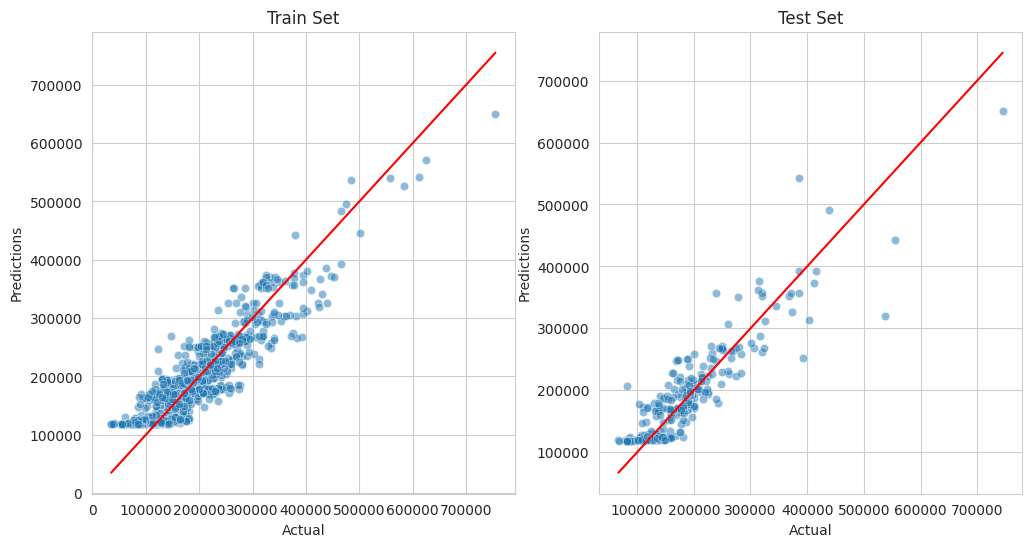

In [30]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* Features importance plot

In [31]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_house_price/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)


## Train Set: features and target

In [32]:
X_train.head()

,GrLivArea,OverallQual,TotalBsmtSF
618,1828,9,1822
870,894,5,894
92,964,5,876
817,1689,8,1568
302,1541,7,1541


In [33]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [34]:
y_train

618     314813
870     109500
92      163500
817     271000
302     205000
         ...  
763     337000
835     128000
1216    112000
559     234000
684     221000
Name: SalePrice, Length: 1168, dtype: int64

In [35]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [36]:
X_test.head()

,GrLivArea,OverallQual,TotalBsmtSF
529,2515,6,2035
491,1578,6,806
459,1203,5,709
279,2022,7,1160
655,1092,6,525


In [37]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [38]:
y_test

529     200624
491     133000
459     110000
279     192000
655      88000
         ...  
326     324000
440     555000
1387    136000
1323     82500
61      101000
Name: SalePrice, Length: 292, dtype: int64

In [39]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [41]:
best_regressor_pipeline

Pipeline(steps=[('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['GrLivArea'])),
                ('PowerTransformer',
                 PowerTransformer(variables=['TotalBsmtSF'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 AdaBoostRegressor(learning_rate=0.01, n_estimators=3000,
                                   random_state=0))])

In [42]:
joblib.dump(value=best_regressor_pipeline, filename=f"{file_path}/house_price_pipeline.pkl")

['outputs/ml_pipeline/predict_house_price/v1/house_price_pipeline.pkl']

## Feature importance plot

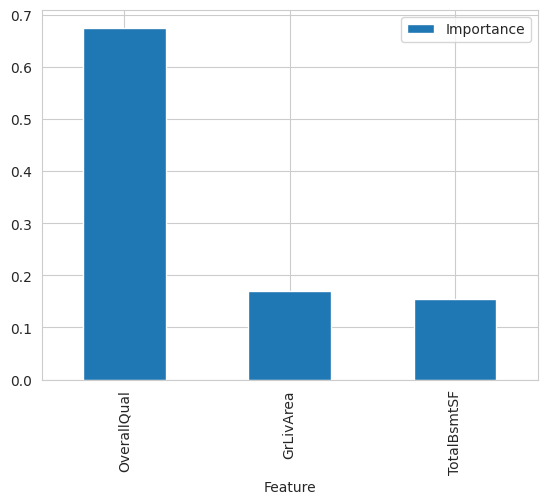

In [43]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

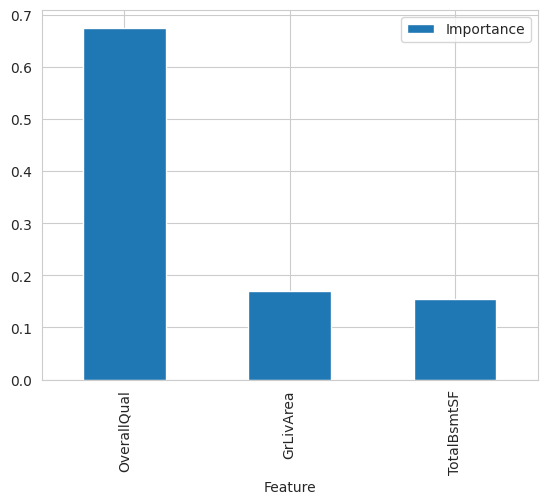

In [44]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')